## Importing Libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import colorsys
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle

## Reading the input data

#### The data was available in Kaggle.com. Originally, this information were obtained from the NASA Langley Research Center (LaRC) POWER Project funded through the NASA Earth Science/Applied Science Program.
#### The U.S. Drought Monitor is produced through a partnership between the National Drought Mitigation Center at the University of Nebraska-Lincoln, the United States Department of Agriculture, and the National Oceanic and Atmospheric Administration.
#### This dataset utilizes the Harmonized World Soil Database by Fischer, G., F. Nachtergaele, S. Prieler, H.T. van Velthuizen, L. Verelst, D. Wiberg, 2008. Global Agro-ecological Zones Assessment for Agriculture (GAEZ 2008). IIASA, Laxenburg, Austria and FAO, Rome, Italy.
#### This Training Data cover the periods of 2000 to 2016.

In [2]:
drought_df = pd.read_csv('../data/train_timeseries.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


## Initial exploration and data cleaning (Data Wrangling)

### In this section, we are looking for number of variables, and size of data. For this set of information, we are working with 3 GB of data.

In [3]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


#### We are looking for null data 

In [4]:
drought_df.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

### Missing value Treatment

#### Missing information is going to be removed by detecting null values in the drought score.

In [5]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

### Reformatting the data

#### In this step we are looking for subdivided the variable date in years, months and days. This information is more relevand and we can apply index type format instead to use "object" format.

In [6]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [7]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int64
month            int64
day              int64
dtype: object

In [8]:
drought_df['fips'].nunique()

3108

In [9]:
drought_df['score'].round().value_counts()

0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: score, dtype: int64

## Exploratory Data Analysis (EDA)

#### We are looking for exploratory data analysis as an approach of analyzing the data sets to summarize their main characteristics, with the use of statistical graphics. The use of EDA is for seeing what the data can tell us beyond the formal modeling and thereby contrasts traditional hypothesis testing.

### Univariate Analysis - Descriptive statistics

#### Univariate analysis explores each variable in a data set, separately. It looks at the range of values, as well as the central tendency of the values. It describes the pattern of response to the variable. It describes each variable on its own.
#### This assessment is done by using 2 methods:
   ##### Skewness: 
    Measure the "sideness" or symmetry of the distribution.
    Skewness can be positive or negative. Negative skew indicates that the tail on the left side of the distribution is  longer or fatter than the right side. Positive skew indicates the converse, the tail on the right side is longer or fatter than the left side. A value of zero indicates the tails on both sides balance; this is the case for symmetric distributions, but also for asymmetric distributions where a short fat tail balances out a long thin tail.

    Uses the Fisher-Pearson standardized moment coefficient G1 definition of sample skewness.
    
   #####  Kurtosis:
    Measure the "tailedness" of the distribution. That is, whether the tails are heavy or light. Excess kurtosis is the kurtosis minus 3 and provides a comparison to the normal distribution.
    Positive excess kurtosis (called leptokurtic) indicates the distribution has fatter tails than a normal distribution. Negative excess kurtosis (called platykurtic) indicates the distribution has thinner tails than a normal distribution.

    Uses the G2 definition of the sample excess kurtosis

In [10]:
# Descriptive statistics
display(drought_df.describe()) # For numeric columns
display(drought_df.describe(include=['object'])) # For Categorical columns
print("\nSkewness: \n", drought_df.skew(axis = 0, skipna = True))
print("\nKurtosis: \n", drought_df.kurtosis(axis = 0, skipna = True))

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
count,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,...,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06
mean,3.067038e+04,2.714566e+00,9.664736e+01,7.875770e+00,1.289923e+01,7.049350e+00,7.084938e+00,1.876711e+01,7.519916e+00,1.124720e+01,...,1.920655e+00,3.282268e+00,5.532799e+00,7.828799e+00,3.121578e+00,4.707223e+00,8.231266e-01,2.007999e+03,6.520857e+00,1.568997e+01
std,1.497911e+04,6.247590e+00,5.444698e+00,4.721459e+00,1.097040e+01,1.019765e+01,1.014364e+01,1.160295e+01,1.061818e+01,4.038022e+00,...,1.342458e+00,1.943136e+00,2.298550e+00,2.836618e+00,2.109945e+00,2.181020e+00,1.239070e+00,4.897714e+00,3.447033e+00,8.798878e+00
min,1.001000e+03,0.000000e+00,6.649000e+01,1.400000e-01,-3.544000e+01,-3.544000e+01,-3.546000e+01,-3.003000e+01,-4.085000e+01,1.600000e-01,...,0.000000e+00,2.600000e-01,5.100000e-01,8.500000e-01,0.000000e+00,4.200000e-01,0.000000e+00,2.000000e+03,1.000000e+00,1.000000e+00
25%,1.904450e+04,0.000000e+00,9.583000e+01,3.810000e+00,4.580000e+00,-8.800000e-01,-8.400000e-01,1.036000e+01,-5.700000e-01,8.370000e+00,...,9.600000e-01,1.820000e+00,3.820000e+00,5.700000e+00,1.450000e+00,3.140000e+00,0.000000e+00,2.004000e+03,4.000000e+00,8.000000e+00
50%,2.921200e+04,1.900000e-01,9.828000e+01,6.940000e+00,1.421000e+01,7.810000e+00,7.810000e+00,2.062000e+01,8.260000e+00,1.120000e+01,...,1.660000e+00,2.820000e+00,5.150000e+00,7.350000e+00,2.770000e+00,4.270000e+00,0.000000e+00,2.008000e+03,7.000000e+00,1.600000e+01
75%,4.600750e+04,2.260000e+00,9.994000e+01,1.145000e+01,2.200000e+01,1.567000e+01,1.567000e+01,2.797000e+01,1.628000e+01,1.408000e+01,...,2.570000e+00,4.280000e+00,6.880000e+00,9.490000e+00,4.390000e+00,5.810000e+00,1.000000e+00,2.012000e+03,1.000000e+01,2.300000e+01
max,5.604300e+04,1.686900e+02,1.037600e+02,2.212000e+01,3.933000e+01,2.687000e+01,2.687000e+01,4.775000e+01,3.228000e+01,3.017000e+01,...,1.462000e+01,1.872000e+01,2.247000e+01,2.833000e+01,1.778000e+01,2.337000e+01,5.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01


,date
count,2756796
unique,887
top,2000-01-04
freq,3108



Skewness: 
 fips          -0.077367
PRECTOT        4.568803
PS            -2.132573
QV2M           0.526605
T2M           -0.426059
T2MDEW        -0.302684
T2MWET        -0.289061
T2M_MAX       -0.467449
T2M_MIN       -0.365648
T2M_RANGE      0.092413
TS            -0.396537
WS10M          1.112524
WS10M_MAX      0.931888
WS10M_MIN      1.400951
WS10M_RANGE    1.287969
WS50M          0.861690
WS50M_MAX      0.899830
WS50M_MIN      0.860444
WS50M_RANGE    1.214403
score          1.498394
year          -0.000183
month         -0.008198
day            0.006969
dtype: float64

Kurtosis: 
 fips           -1.100136
PRECTOT        33.304567
PS              4.813301
QV2M           -0.786067
T2M            -0.554336
T2MDEW         -0.733896
T2MWET         -0.758504
T2M_MAX        -0.508101
T2M_MIN        -0.446940
T2M_RANGE      -0.316984
TS             -0.535722
WS10M           1.419724
WS10M_MAX       0.705953
WS10M_MIN       3.159288
WS10M_RANGE     2.084432
WS50M           0.819908
WS50M_M

In [11]:
column_list = list(drought_df.columns)
column_list

['fips',
 'date',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

### Univariate Analysis - Distribution of continuous variables

In [12]:
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

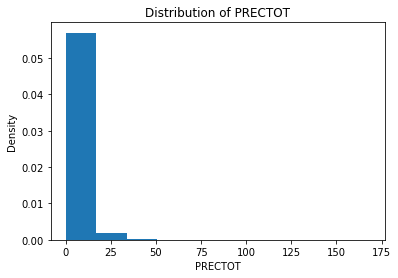

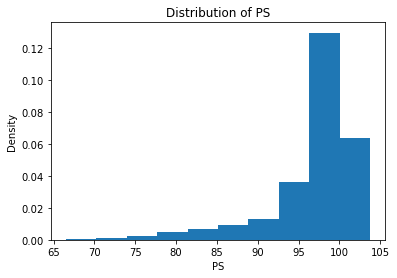

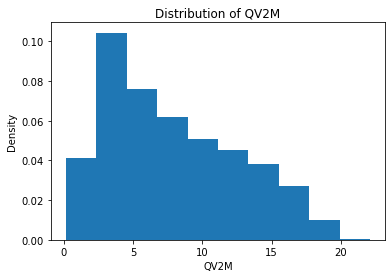

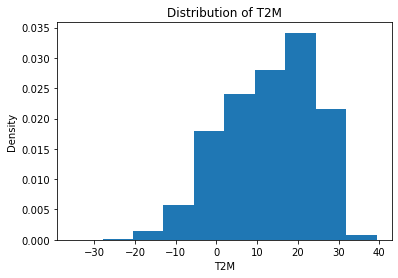

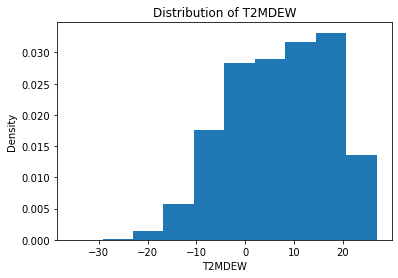

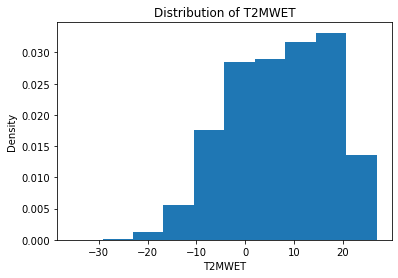

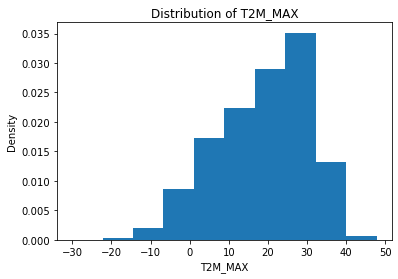

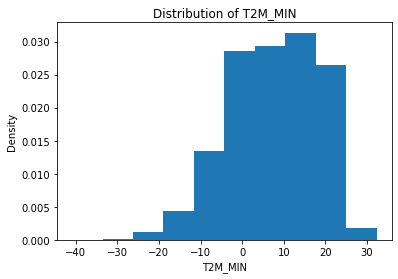

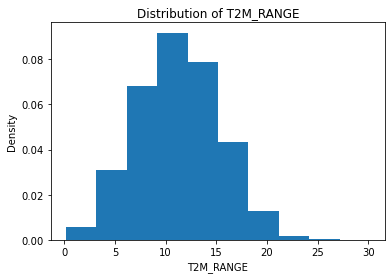

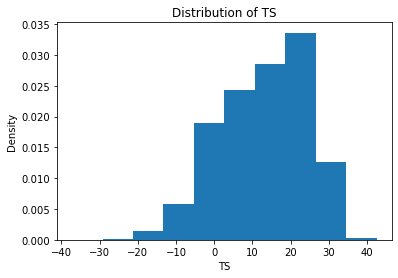

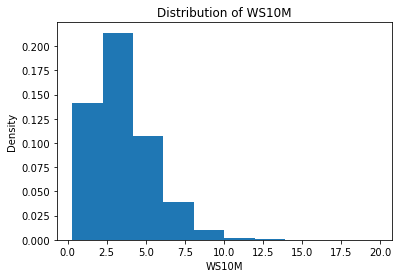

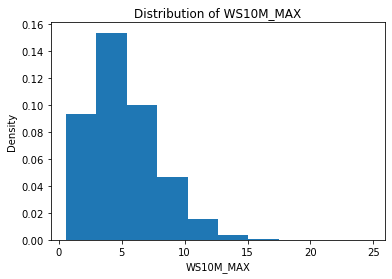

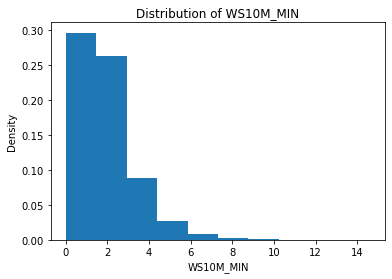

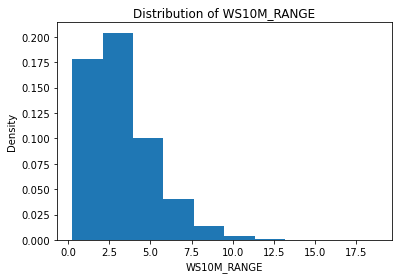

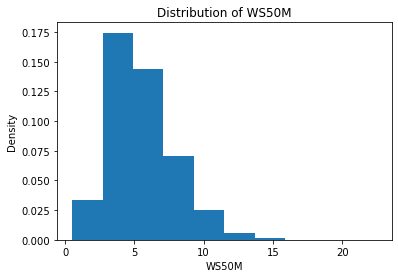

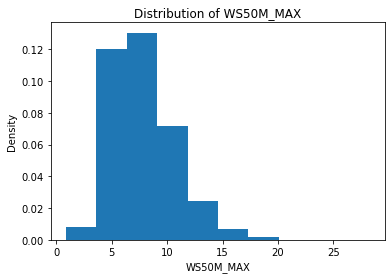

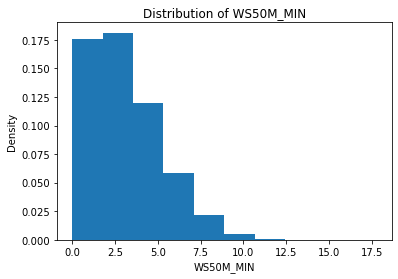

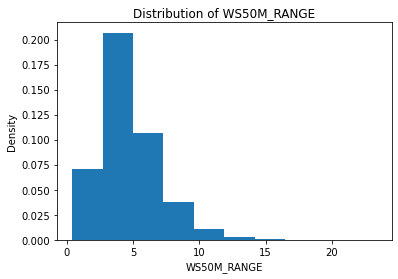

In [13]:
for col_name in measures_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.savefig('Distribution1 of '+ x_name,dpi=300)

## Outlier Treatment

### Identifying Outliers

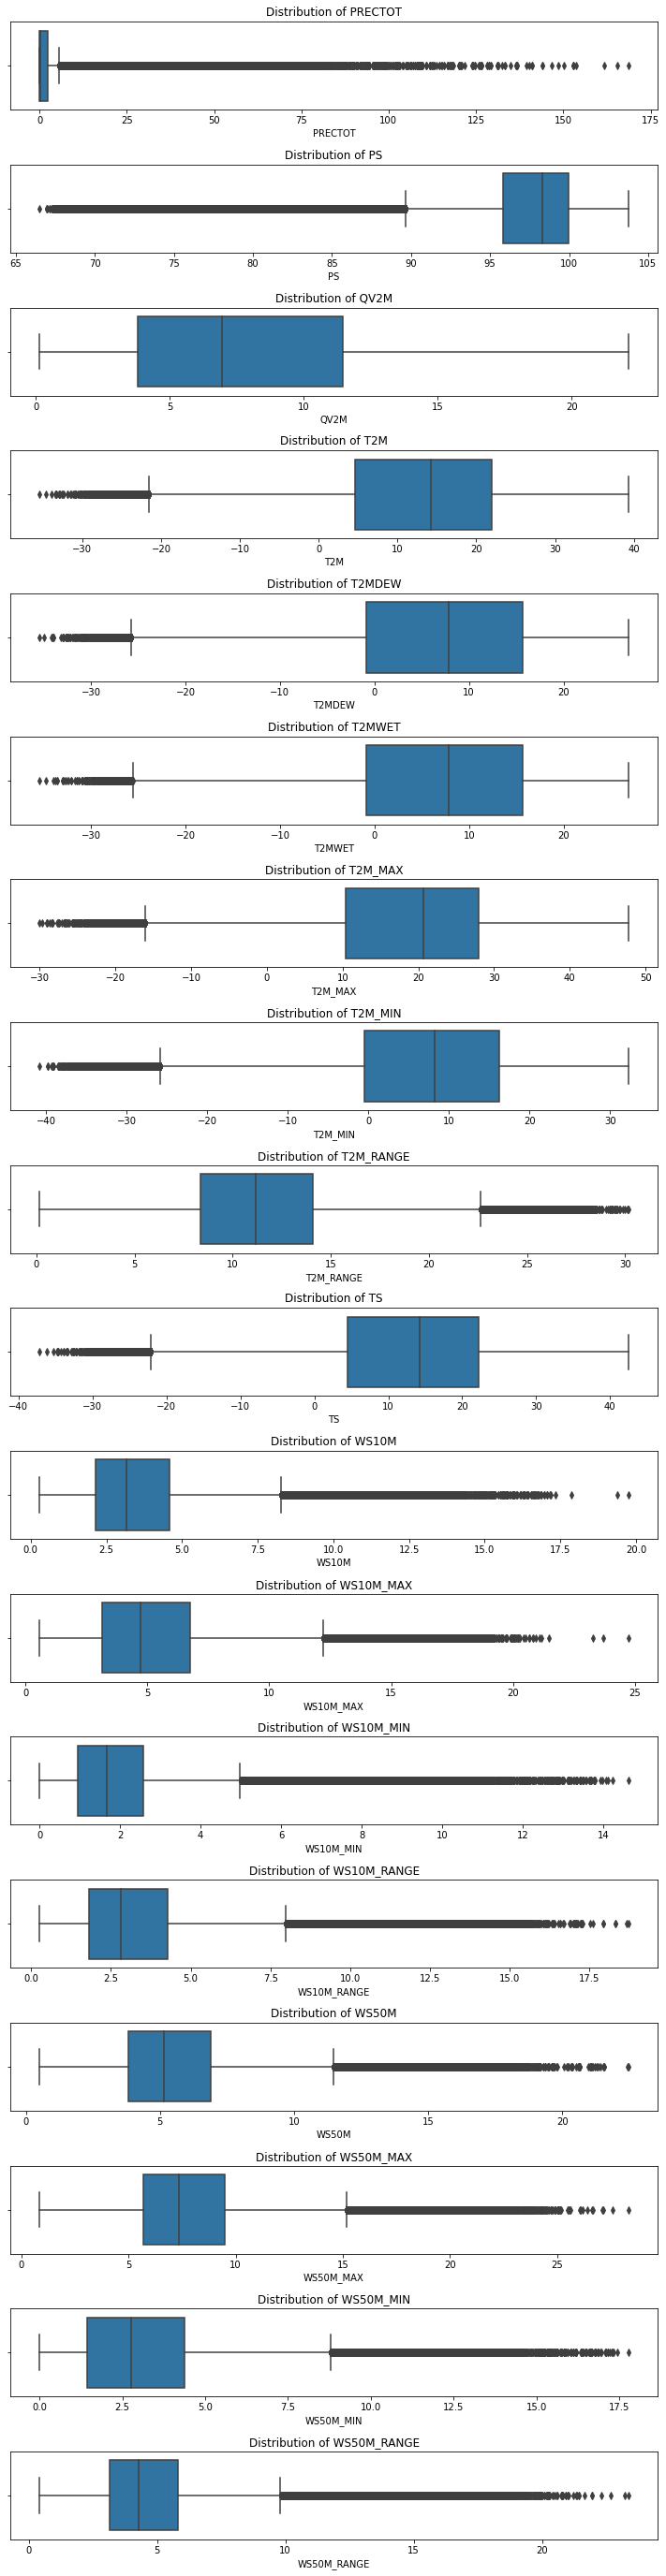

In [14]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')
    plt.savefig('Outlier of '+x_name,dpi=300)
plt.tight_layout()

In [15]:
print('Total rows = ',len(drought_df_measures.index))
for i in drought_df_measures.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyong standard outlier limit in ', i)
    print(len(drought_df_measures[(drought_df_measures[i] > drought_df_measures[i].mean() + 3*drought_df_measures[i].std()) | (drought_df_measures[i] < drought_df_measures[i].mean() - 3*drought_df_measures[i].std())]))

Total rows =  2756796
Number of values beyong standard outlier limit in  PRECTOT
65933
Number of values beyong standard outlier limit in  PS
73197
Number of values beyong standard outlier limit in  QV2M
1
Number of values beyong standard outlier limit in  T2M
4531
Number of values beyong standard outlier limit in  T2MDEW
2023
Number of values beyong standard outlier limit in  T2MWET
1814
Number of values beyong standard outlier limit in  T2M_MAX
3384
Number of values beyong standard outlier limit in  T2M_MIN
6944
Number of values beyong standard outlier limit in  T2M_RANGE
3628
Number of values beyong standard outlier limit in  TS
4762
Number of values beyong standard outlier limit in  WS10M
29954
Number of values beyong standard outlier limit in  WS10M_MAX
23387
Number of values beyong standard outlier limit in  WS10M_MIN
39901
Number of values beyong standard outlier limit in  WS10M_RANGE
35979
Number of values beyong standard outlier limit in  WS50M
23090
Number of values beyong sta

### Removing values beyond the standard outlier limit

In [16]:
drought_df = drought_df[(drought_df['PRECTOT'] <= drought_df['PRECTOT'].mean() + 3*drought_df['PRECTOT'].std()) &
        (drought_df['PRECTOT'] >= drought_df['PRECTOT'].mean() - 3*drought_df['PRECTOT'].std())]

drought_df = drought_df[(drought_df['PS'] <= drought_df['PS'].mean() + 3*drought_df['PS'].std()) &
        (drought_df['PS'] >= drought_df['PS'].mean() - 3*drought_df['PS'].std())]

drought_df = drought_df[(drought_df['QV2M'] <= drought_df['QV2M'].mean() + 3*drought_df['QV2M'].std()) &
        (drought_df['QV2M'] >= drought_df['QV2M'].mean() - 3*drought_df['QV2M'].std())]

drought_df = drought_df[(drought_df['T2M'] <= drought_df['T2M'].mean() + 3*drought_df['T2M'].std()) &
        (drought_df['T2M'] >= drought_df['T2M'].mean() - 3*drought_df['T2M'].std())]

drought_df = drought_df[(drought_df['T2MDEW'] <= drought_df['T2MDEW'].mean() + 3*drought_df['T2MDEW'].std()) &
        (drought_df['T2MDEW'] >= drought_df['T2MDEW'].mean() - 3*drought_df['T2MDEW'].std())]

drought_df = drought_df[(drought_df['T2MWET'] <= drought_df['T2MWET'].mean() + 3*drought_df['T2MWET'].std()) &
        (drought_df['T2MWET'] >= drought_df['T2MWET'].mean() - 3*drought_df['T2MWET'].std())]

drought_df = drought_df[(drought_df['T2M_MAX'] <= drought_df['T2M_MAX'].mean() + 3*drought_df['T2M_MAX'].std()) &
        (drought_df['T2M_MAX'] >= drought_df['T2M_MAX'].mean() - 3*drought_df['T2M_MAX'].std())]

drought_df = drought_df[(drought_df['T2M_MIN'] <= drought_df['T2M_MIN'].mean() + 3*drought_df['T2M_MIN'].std()) &
        (drought_df['T2M_MIN'] >= drought_df['T2M_MIN'].mean() - 3*drought_df['T2M_MIN'].std())]

drought_df = drought_df[(drought_df['T2M_RANGE'] <= drought_df['T2M_RANGE'].mean() + 3*drought_df['T2M_RANGE'].std()) &
        (drought_df['T2M_RANGE'] >= drought_df['T2M_RANGE'].mean() - 3*drought_df['T2M_RANGE'].std())]

drought_df = drought_df[(drought_df['TS'] <= drought_df['TS'].mean() + 3*drought_df['TS'].std()) &
        (drought_df['TS'] >= drought_df['TS'].mean() - 3*drought_df['TS'].std())]

drought_df = drought_df[(drought_df['WS10M'] <= drought_df['WS10M'].mean() + 3*drought_df['WS10M'].std()) &
        (drought_df['WS10M'] >= drought_df['WS10M'].mean() - 3*drought_df['WS10M'].std())]

drought_df = drought_df[(drought_df['WS10M_MAX'] <= drought_df['WS10M_MAX'].mean() + 3*drought_df['WS10M_MAX'].std()) &
        (drought_df['WS10M_MAX'] >= drought_df['WS10M_MAX'].mean() - 3*drought_df['WS10M_MAX'].std())]

drought_df = drought_df[(drought_df['WS10M_MIN'] <= drought_df['WS10M_MIN'].mean() + 3*drought_df['WS10M_MIN'].std()) &
        (drought_df['WS10M_MIN'] >= drought_df['WS10M_MIN'].mean() - 3*drought_df['WS10M_MIN'].std())]

drought_df = drought_df[(drought_df['WS10M_RANGE'] <= drought_df['WS10M_RANGE'].mean() + 3*drought_df['WS10M_RANGE'].std()) &
        (drought_df['WS10M_RANGE'] >= drought_df['WS10M_RANGE'].mean() - 3*drought_df['WS10M_RANGE'].std())]

drought_df = drought_df[(drought_df['WS50M'] <= drought_df['WS50M'].mean() + 3*drought_df['WS50M'].std()) &
        (drought_df['WS50M'] >= drought_df['WS50M'].mean() - 3*drought_df['WS50M'].std())]

drought_df = drought_df[(drought_df['WS50M_MAX'] <= drought_df['WS50M_MAX'].mean() + 3*drought_df['WS50M_MAX'].std()) &
        (drought_df['WS50M_MAX'] >= drought_df['WS50M_MAX'].mean() - 3*drought_df['WS50M_MAX'].std())]

drought_df = drought_df[(drought_df['WS50M_MIN'] <= drought_df['WS50M_MIN'].mean() + 3*drought_df['WS50M_MIN'].std()) &
        (drought_df['WS50M_MIN'] >= drought_df['WS50M_MIN'].mean() - 3*drought_df['WS50M_MIN'].std())]

drought_df = drought_df[(drought_df['WS50M_RANGE'] <= drought_df['WS50M_RANGE'].mean() + 3*drought_df['WS50M_RANGE'].std()) &
        (drought_df['WS50M_RANGE'] >= drought_df['WS50M_RANGE'].mean() - 3*drought_df['WS50M_RANGE'].std())]

print('Total rows = ',len(drought_df.index))

Total rows =  2474338


In [17]:
drought_df.to_csv("clean_data/drought.csv",encoding="utf-8", index=False, header=True)

### Univariate Analysis - Distribution of categorical variables

In [18]:
categorical_column_list = ['score','year','month','day']
drought_df_categorical = drought_df[['score','year','month','day']]

<Figure size 720x2880 with 0 Axes>

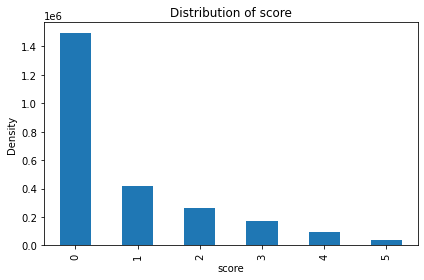

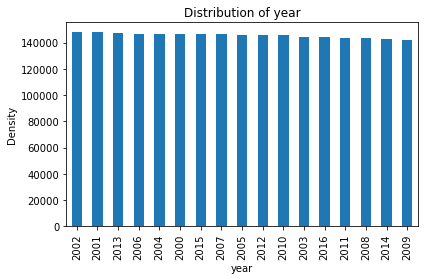

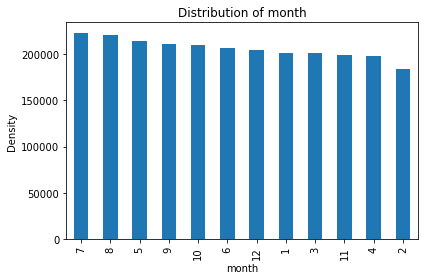

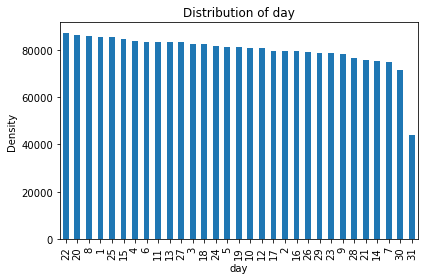

In [19]:
# Distribution of categorical variables
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    drought_df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.savefig('Distribution2 of '+ x_name ,dpi=300)
    plt.tight_layout()

### Bivariate Analysis

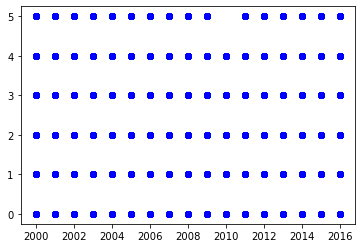

In [20]:
plt.scatter(drought_df['year'], drought_df['score'], c ="blue")
plt.show()
plt.savefig('Scatter Plot of time vs score',dpi=300)

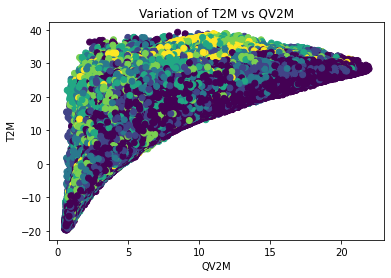

In [21]:
plt.scatter(drought_df['QV2M'], drought_df['T2M'], c =drought_df['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.savefig('Variation of T2M vs QV2M',dpi=300)
plt.show()

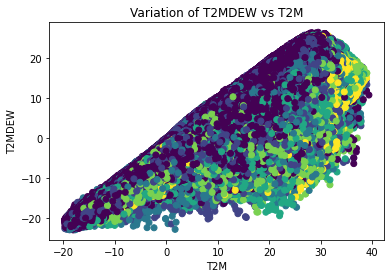

In [22]:
plt.scatter(drought_df['T2M'], drought_df['T2MDEW'], c =drought_df['score'])
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
plt.savefig('Variation of T2MDEW vs T2M',dpi=300)
plt.show()

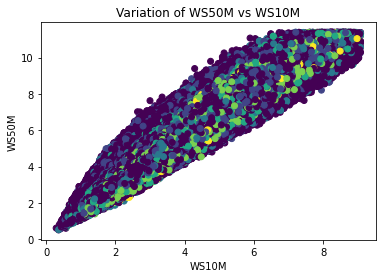

In [23]:
temp_df = drought_df[drought_df['score']==5]
plt.scatter(drought_df['WS10M'], drought_df['WS50M'], c= drought_df['score'])
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
plt.savefig('Variation of WS50M vs WS10M',dpi=300)
plt.show()

### Extracting Dependent and Independent Variables

In [24]:
independent_variables = drought_df.drop('score', 1)
independent_variables = independent_variables.drop('fips', 1)
independent_variables = independent_variables.drop('date', 1)
independent_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
3,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,...,5.67,2.08,3.59,6.73,9.31,3.74,5.58,2000,1,4
10,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,10.43,...,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2000,1,11
17,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,14.19,...,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2000,1,18
24,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,-0.61,...,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2000,1,25
31,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,...,2.74,0.88,1.86,4.18,6.38,1.27,5.11,2000,2,1


In [25]:
independent_variables.to_csv("clean_data/independent_variables_clean_drought.csv",encoding="utf-8", index=False, header=True)

In [26]:
target = drought_df['score']
target.head()

3     1
10    2
17    2
24    2
31    1
Name: score, dtype: int32

## Correlation between independent variables for Feature Selection

In [27]:
correlation_plot = drought_df_measures.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.068775,0.245081,0.093258,0.231035,0.230975,0.026773,0.144929,-0.304171,0.089598,0.049730,0.060981,0.023346,0.065755,0.069057,0.079508,0.057816,0.047477
PS,0.068775,1.000000,0.282412,0.164160,0.341234,0.341252,0.111979,0.208285,-0.225935,0.163830,-0.080747,-0.135905,0.022932,-0.198332,-0.043315,-0.091821,0.036238,-0.154479
QV2M,0.245081,0.282412,1.000000,0.870242,0.959385,0.960434,0.804338,0.906144,-0.071547,0.862559,-0.225449,-0.256452,-0.108789,-0.269203,-0.205971,-0.249961,-0.081554,-0.246203
T2M,0.093258,0.164160,0.870242,1.000000,0.913530,0.914218,0.983356,0.981629,0.244357,0.997515,-0.207874,-0.220192,-0.125407,-0.209030,-0.193196,-0.206444,-0.112579,-0.159589
T2MDEW,0.231035,0.341234,0.959385,0.913530,1.000000,0.999970,0.854716,0.939934,-0.015643,0.905184,-0.238299,-0.268686,-0.115920,-0.280702,-0.204238,-0.245323,-0.082416,-0.239335
T2MWET,0.230975,0.341252,0.960434,0.914218,0.999970,1.000000,0.855401,0.940629,-0.015500,0.905911,-0.237971,-0.268292,-0.115882,-0.280199,-0.204143,-0.245147,-0.082497,-0.239029
T2M_MAX,0.026773,0.111979,0.804338,0.983356,0.854716,0.855401,1.000000,0.937762,0.407534,0.980101,-0.216764,-0.221671,-0.141911,-0.199614,-0.195727,-0.196236,-0.133234,-0.126331
T2M_MIN,0.144929,0.208285,0.906144,0.981629,0.939934,0.940629,0.937762,1.000000,0.065037,0.979134,-0.206382,-0.225829,-0.112878,-0.225256,-0.197991,-0.225744,-0.096593,-0.200157
T2M_RANGE,-0.304171,-0.225935,-0.071547,0.244357,-0.015643,-0.015500,0.407534,0.065037,1.000000,0.241564,-0.080163,-0.043127,-0.110952,0.018746,-0.041778,0.029737,-0.128844,0.163320
TS,0.089598,0.163830,0.862559,0.997515,0.905184,0.905911,0.980101,0.979134,0.241564,1.000000,-0.189823,-0.202713,-0.110273,-0.196015,-0.180665,-0.193347,-0.102367,-0.152434


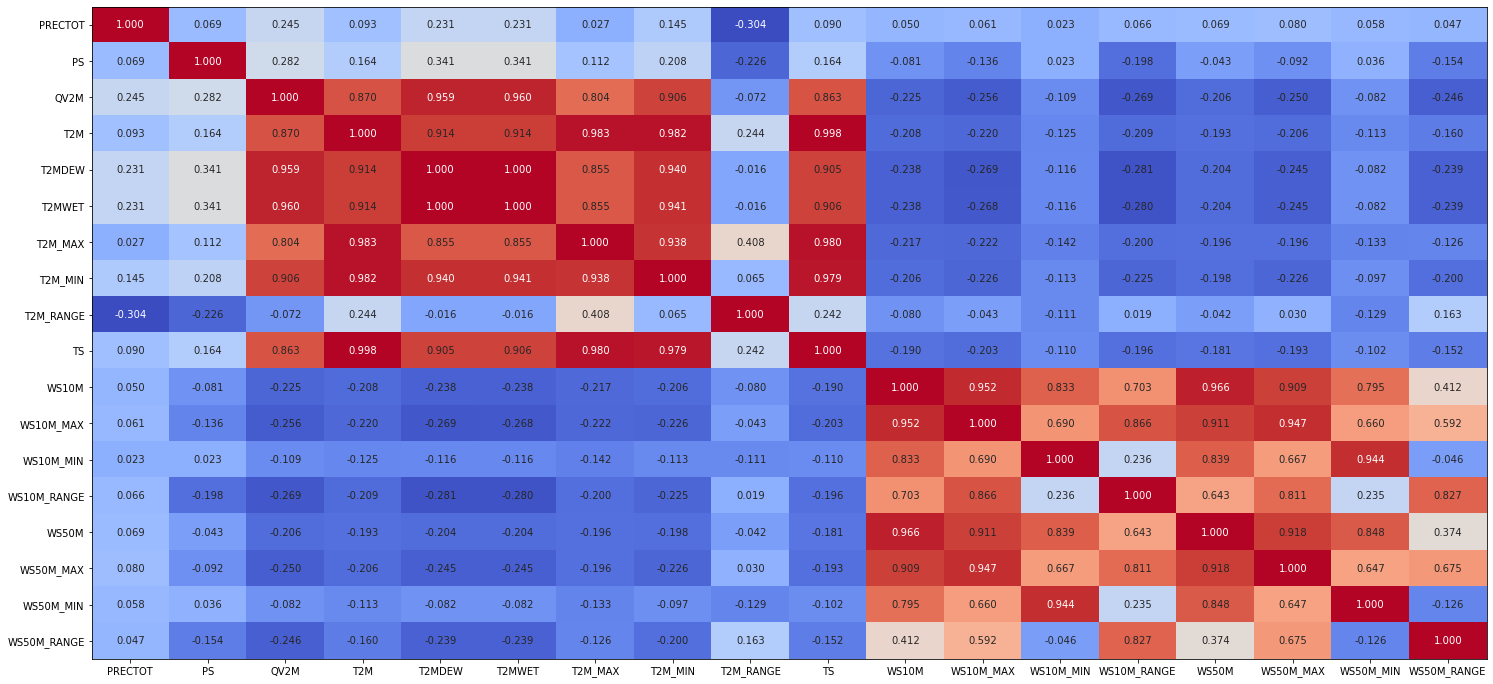

In [28]:
### code for save in picture format

fig, ax = plt.subplots(figsize=(25, 12))
data = correlation_plot.values
heatmap = ax.pcolor(data, cmap=plt.get_cmap('coolwarm'), 
                    vmin=np.nanmin(data), vmax=np.nanmax(data))
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.invert_yaxis()
row_labels = correlation_plot.index
column_labels = correlation_plot.columns
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

def _annotate_heatmap(ax, mesh):
    """
    **Taken from seaborn/matrix.py**
    Add textual labels with the value in each cell.
    """
    mesh.update_scalarmappable()
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                mesh.get_array(), mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:.3f}").format(val)
            text_kwargs = dict(color=text_color, ha="center", va="center")
            # text_kwargs.update(self.annot_kws)
            ax.text(x, y, val, **text_kwargs)

_annotate_heatmap(ax, heatmap)
plt.savefig('Correlation Matrix.png', bbox_inches='tight', pad_inches=0.0)


#### Attributes QV2M, T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN and TS have shown strong positive correlation
#### Similary WS10M, WS10M_MAX and WS10M_MIN have shown a strong positve correlation
#### Likewise, WS50M, WS50M_MAX and WS50M_MIN show strong positive correlation
#### However, from the scatter plots above, we see significant variance between the data points, despite the strong positive correlation. Hence we'll retain all these variables, and try other feature selection methods.

## Splitting into train and test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

In [30]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (1979470, 21)
Train target shape (1979470,)
Test features shape (494868, 21)
Test target shape (494868,)


## Standardizing the data

In [31]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 2.39997504, -0.78416609,  0.74119512, ..., -1.42190019,
        -0.16603116,  1.17395993],
       [ 2.44655066,  0.37551891, -0.51918943, ...,  0.61688719,
         1.00794799,  0.26443762],
       [-0.51617644, -0.98505641, -1.00721711, ..., -1.62577893,
         1.30144278, -0.19032353],
       ...,
       [ 2.73117947, -1.01929907, -0.79927488, ...,  0.61688719,
         1.59493757,  1.28765022],
       [ 0.22385845,  0.40519588,  1.29500045, ...,  1.2285234 ,
         0.7144532 , -1.55460699],
       [-0.51617644,  0.75903678,  1.43292132, ..., -1.01414272,
        -0.16603116,  0.94657935]])

## Feature Selection using RFE and Random Forest algorithm

In [32]:
model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter
rfe = RFE(model, n_features_to_select=6) # n_features_to_select is chosen on a trial and error basis
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = independent_variables.columns[(fit.get_support())]
print(selected_features)

Num Features: 6
Selected Features: [False  True False False  True False  True False  True  True False False
 False False  True False False False False False False]
Feature Ranking: [13  1  5  8  1 11  1  4  1  1 10 14 15  7  1  2 12  9  6 16  3]
Index(['PS', 'T2MDEW', 'T2M_MAX', 'T2M_RANGE', 'TS', 'WS50M'], dtype='object')


In [33]:
independent_variables = independent_variables.drop('PRECTOT', 1)
independent_variables = independent_variables.drop('QV2M', 1)
independent_variables = independent_variables.drop('T2M', 1)
independent_variables = independent_variables.drop('T2MWET', 1)
independent_variables = independent_variables.drop('T2M_MIN', 1)
independent_variables = independent_variables.drop('WS10M', 1)
independent_variables = independent_variables.drop('WS10M_MAX', 1)
independent_variables = independent_variables.drop('WS10M_MIN', 1)
independent_variables = independent_variables.drop('WS10M_RANGE', 1)
independent_variables = independent_variables.drop('WS50M_MAX', 1)
independent_variables = independent_variables.drop('WS50M_MIN', 1)
independent_variables = independent_variables.drop('WS50M_RANGE', 1)
independent_variables = independent_variables.drop('year', 1)
independent_variables = independent_variables.drop('month', 1)
independent_variables = independent_variables.drop('day', 1)


independent_variables.head()


X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train features shape (1979470, 6)
Train target shape (1979470,)
Test features shape (494868, 6)
Test target shape (494868,)


In [34]:
independent_variables.to_csv("clean_data/independent_variables_clean_drought_6variables.csv",encoding="utf-8", index=False, header=True)

In [66]:
pickle.dump(sc, open('RF_classifier_sc.pkl', 'wb'))

## Testing pkl for user data as a input

In [67]:
testuser =np.array([100.29,18.69,34.95,13.14,28.81,4.08])
X_testuser = sc.transform(testuser.reshape(1,-1))
X_testuser

array([[ 0.69511713,  1.11682742,  1.3704757 ,  0.47511168,  1.39276592,
        -0.59428913]])

In [68]:
sc_test= pickle.load(open("RF_classifier_sc.pkl", "rb"))
X_testuser = sc_test.transform(testuser.reshape(1,-1))
X_testuser

array([[ 0.69511713,  1.11682742,  1.3704757 ,  0.47511168,  1.39276592,
        -0.59428913]])

In [69]:
y_pred_RF_test = RF_classifier.predict(X_testuser)

y_pred_RF_test

array([3])

## Model Development

### Decision Tree Algorithm withot resampling

In [38]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [39]:
print('Performance of Decision Tree Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling:

[[246655  27235  12560   7588   3836   1371]
 [ 27390  40699   8910   3624   1748    695]
 [ 11795   9920  23340   5287   1603    604]
 [  7230   3546   6049  14402   2743    523]
 [  3481   1889   1659   3050   7399    942]
 [  1229    707    598    569   1048   2944]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.83    299245
           1       0.48      0.49      0.49     83066
           2       0.44      0.44      0.44     52549
           3       0.42      0.42      0.42     34493
           4       0.40      0.40      0.40     18420
           5       0.42      0.41      0.42      7095

    accuracy                           0.68    494868
   macro avg       0.50      0.50      0.50    494868
weighted avg       0.68      0.68      0.68    494868

Accuracy: 0.6778353015349547
Precision: 0.6788990485684602
Recall: 0.6778353015349547
F1 Score: 0.678360248705082
Cohen Kappa 

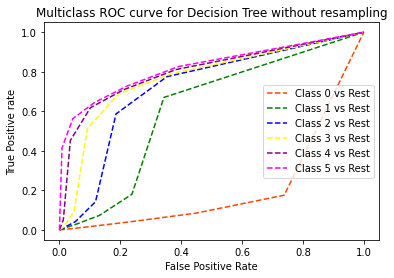

In [40]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling',dpi=300)

### Decision Tree Algorithm without resampling - Hyperparameter Tuning

In [41]:
DT_classifier.get_depth()

62

In [42]:
params = {
          'max_depth': [40, 50, 60, 70, 80],
#           'max_samples_leaf': [, 20, 50, 100],
          'max_features':['log2','sqrt',None]
}

In [43]:
grid_search = GridSearchCV(estimator=DT_classifier, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [44]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Wall time: 4min 43s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60, 70, 80],
                         'max_features': ['log2', 'sqrt', None]},
             scoring='accuracy', verbose=1)

In [45]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,33.237220,0.404180,0.484625,0.007781,80,None,"{'max_depth': 80, 'max_features': None}",0.641634,0.643361,0.642653,0.642692,0.642585,0.000617,1
5,47.206240,0.639391,0.814370,0.025206,50,None,"{'max_depth': 50, 'max_features': None}",0.641367,0.643250,0.642716,0.642847,0.642545,0.000708,2
8,47.871147,0.897859,0.784795,0.058360,60,None,"{'max_depth': 60, 'max_features': None}",0.641607,0.643485,0.642401,0.642684,0.642544,0.000671,3
11,46.047084,0.300348,0.660329,0.080844,70,None,"{'max_depth': 70, 'max_features': None}",0.641618,0.643515,0.642094,0.642803,0.642507,0.000719,4
2,47.526522,0.745533,0.706899,0.033149,40,None,"{'max_depth': 40, 'max_features': None}",0.641183,0.643200,0.642425,0.643138,0.642487,0.000812,5


### Decision Tree Algorithm without resampling - Setting the right hyperparameters

In [46]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=70)
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [47]:
pickle.dump(DT_classifier, open('DT_classifier.pkl', 'wb'))

In [48]:
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT, average='weighted')
dt_recall = recall_score(y_test, y_pred_DT, average='weighted')
dt_f1_score = f1_score(y_test, y_pred_DT, average='weighted')
dt_cohen_kappa_score = cohen_kappa_score(y_test, y_pred_DT)

In [49]:
print('Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:

[[246640  27165  12689   7587   3792   1372]
 [ 27340  40732   8973   3606   1729    686]
 [ 11785   9946  23288   5362   1558    610]
 [  7308   3586   6074  14326   2686    513]
 [  3492   1855   1671   3029   7446    927]
 [  1248    698    588    548   1060   2953]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.83    299245
           1       0.49      0.49      0.49     83066
           2       0.44      0.44      0.44     52549
           3       0.42      0.42      0.42     34493
           4       0.41      0.40      0.41     18420
           5       0.42      0.42      0.42      7095

    accuracy                           0.68    494868
   macro avg       0.50      0.50      0.50    494868
weighted avg       0.68      0.68      0.68    494868

Accuracy: 0.6777261815271951
Precision: 0.6787574895053567
Recall: 0.6777261815271951
F1 Score: 

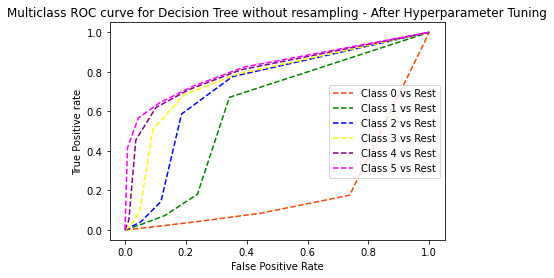

In [50]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning',dpi=300)

### Random Forest Algorithm without resampling

In [51]:
RF_classifier = RandomForestClassifier(n_estimators = 20, max_depth=70, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [52]:
print('Performance of RF Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',accuracy_score(y_test, y_pred_RF))
print('Precision:',precision_score(y_test, y_pred_RF, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_RF, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_RF, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_RF))

Performance of RF Algorithm without resampling:

[[282466  11675   2875   1582    553     94]
 [ 38179  36961   6114   1379    338     95]
 [ 18969   7407  21595   3946    517    115]
 [ 11930   2316   4509  13694   1876    168]
 [  5878   1327   1141   2385   6990    699]
 [  2036    521    422    373    780   2963]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86    299245
           1       0.61      0.44      0.52     83066
           2       0.59      0.41      0.48     52549
           3       0.59      0.40      0.47     34493
           4       0.63      0.38      0.47     18420
           5       0.72      0.42      0.53      7095

    accuracy                           0.74    494868
   macro avg       0.65      0.50      0.56    494868
weighted avg       0.72      0.74      0.71    494868

Accuracy: 0.7369015575870738
Precision: 0.7154562883084277
Recall: 0.7369015575870738
F1 Score: 0.7148504178166684
Cohen Kappa Score: 0.5

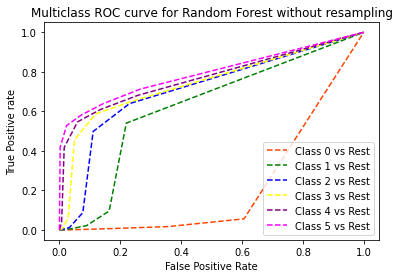

In [53]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Random Forest without resampling',dpi=300)

### Random Forest Algorithm without resampling - Hyperparameter Tuning

In [54]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [55]:
RF_random = RandomizedSearchCV(estimator = RF_classifier, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
RF_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=70,
                                                    n_estimators=20,
                                                    random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 14, 18, 23, 27, 32,
                                                         36, 41, 45, 50]},
                   random_state=0, verbose=2)

In [56]:
RF_random.best_params_

{'n_estimators': 50,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

### Random Forest Algorithm without resampling - Setting the right Hyperparameters

In [57]:
RF_classifier = RandomForestClassifier(n_estimators = 50, max_depth=80, bootstrap=False, max_features='sqrt', random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [58]:
pickle.dump(RF_classifier, open('RF_classifier.pkl', 'wb'))

## Compress the final ML pkl model to be able to use in Github and Heroku

In [59]:
import gzip, pickle, pickletools

In [60]:
filepath = "RF_classifier.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(RF_classifier)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

## Confusion matrix and classification report

In [61]:
rf_accuracy = accuracy_score(y_test, y_pred_RF)
rf_precision = precision_score(y_test, y_pred_RF, average='weighted')
rf_recall = recall_score(y_test, y_pred_RF, average='weighted')
rf_f1_score = f1_score(y_test, y_pred_RF, average='weighted')
rf_cohen_kappa_score = cohen_kappa_score(y_test, y_pred_RF)

In [62]:
print('Performance of RF Algorithm without resampling - After Hyperparamter Tuning:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',rf_accuracy)
print('Precision:',rf_precision)
print('Recall:',rf_recall)
print('F1 Score:',rf_f1_score)
print('Cohen Kappa Score:',rf_cohen_kappa_score)

Performance of RF Algorithm without resampling - After Hyperparamter Tuning:

[[283544  10757   2663   1632    549    100]
 [ 37483  37892   5855   1327    410     99]
 [ 18215   7688  22177   3838    518    113]
 [ 11427   2109   4845  14137   1827    148]
 [  5658   1134   1076   2635   7228    689]
 [  1927    472    384    361    908   3043]]
              precision    recall  f1-score   support

           0       0.79      0.95      0.86    299245
           1       0.63      0.46      0.53     83066
           2       0.60      0.42      0.50     52549
           3       0.59      0.41      0.48     34493
           4       0.63      0.39      0.48     18420
           5       0.73      0.43      0.54      7095

    accuracy                           0.74    494868
   macro avg       0.66      0.51      0.57    494868
weighted avg       0.72      0.74      0.72    494868

Accuracy: 0.7436750810317094
Precision: 0.7232566901554951
Recall: 0.7436750810317094
F1 Score: 0.7225073834

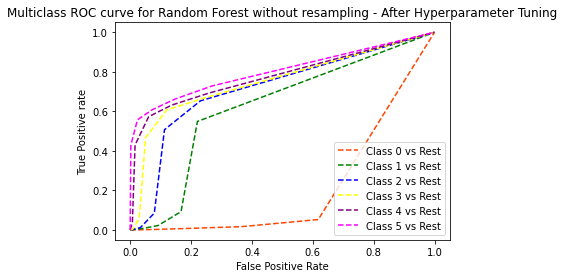

In [63]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning',dpi=300)

## Performance Analysis

In [64]:
all_labels = pd.DataFrame()
all_labels['Actual_label'] = y_test
all_labels['y_pred_DT'] = y_pred_DT
all_labels['y_pred_RF'] = y_pred_RF

In [65]:
data = [
{'Algorithm':'Decision Tree without resampling' ,'Accuracy':dt_accuracy,'Precision':dt_precision,'Recall':dt_recall,'F1 Score':dt_f1_score,'Cohen Kappa Score':dt_cohen_kappa_score},
{'Algorithm':'Random Forest without resampling','Accuracy':rf_accuracy,'Precision':rf_precision,'Recall':rf_recall,'F1 Score':rf_f1_score,'Cohen Kappa Score':rf_cohen_kappa_score}
]
performance_metrics = pd.DataFrame(data)
performance_metrics.sort_values(by=['Accuracy', 'Cohen Kappa Score'], ascending=False)

,Algorithm,Accuracy,Precision,Recall,F1 Score,Cohen Kappa Score
1,Random Forest without resampling,0.743675,0.723257,0.743675,0.722507,0.515981
0,Decision Tree without resampling,0.677726,0.678757,0.677726,0.678234,0.453533
